In [1]:
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# Regression Decision Tree

In [2]:
iris = sns.load_dataset("iris")
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
iris["species"].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [5]:
# object type -> category
iris["species"] = iris["species"].map({"setosa":1, "versicolor":2, "virginica":3}).astype("category")
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sepal_length  150 non-null    float64 
 1   sepal_width   150 non-null    float64 
 2   petal_length  150 non-null    float64 
 3   petal_width   150 non-null    float64 
 4   species       150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB


In [6]:
# split into 7:3
X_iris = iris.drop(["sepal_width"], axis=1)
y_iris = iris["sepal_width"]
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.3, random_state=42)
# ============================================
print(f"============ train set ============\nX_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"============ test  set ============\nX_test:  {X_test.shape}, y_test:  {y_test.shape}\n===================================")

============ train set ============
X_train: (105, 4), y_train: (105,)
============ test  set ============
X_test:  (45, 4), y_test:  (45,)


In [7]:
reg_dt = DecisionTreeRegressor()
reg_dt.fit(X_train, y_train)

reg_y_train = reg_dt.predict(X_train)
reg_y_test = reg_dt.predict(X_test)

reg_train_mse = ((y_train - reg_y_train)**2).mean()
reg_test_mse = ((y_test - reg_y_test)**2).mean()

print(f"MSE of Regression Tree train : {round(reg_train_mse, 5)}")
print(f"MSE of Regression Tree test  : {round(reg_test_mse, 5)}")

MSE of Regression Tree train : 0.00019
MSE of Regression Tree test  : 0.17622


## Visualization

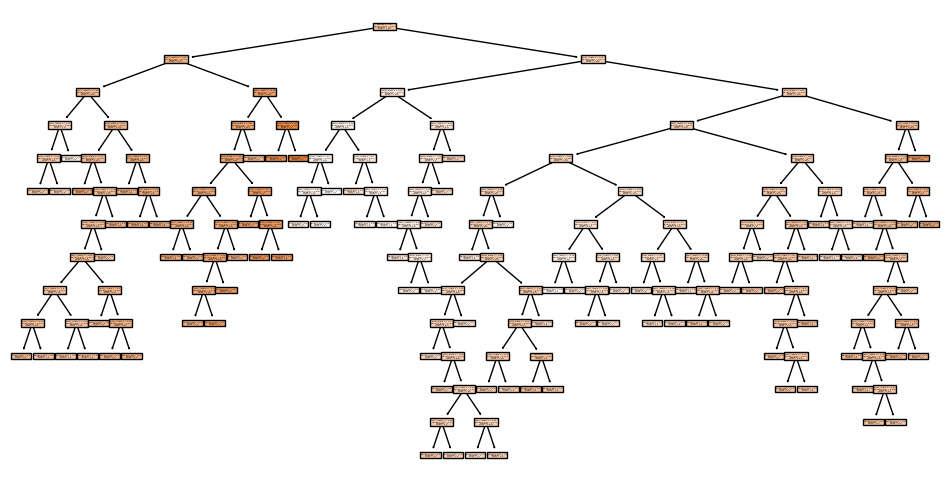

In [8]:
plt.figure(figsize=(12,6))
plot_tree(reg_dt, filled=True, feature_names=X_train.columns, class_names=['setosa', 'versicolor', 'virginica'])
plt.show()

## pruning

In [9]:
path = reg_dt.cost_complexity_pruning_path(X_train, y_train)
# 'ccp_alphas': array([0.00000000e+00, 5.07406617e-17, 3.38353684e-17, 4.76190476e-05,
# 'impurities': array([0.00019048, 0.00019048, 0.00019048, 0.00025397, 0.00030159,

ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas = np.abs(ccp_alphas) # 부동 소수점에 의한 음수값 없애기 위한 작업

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

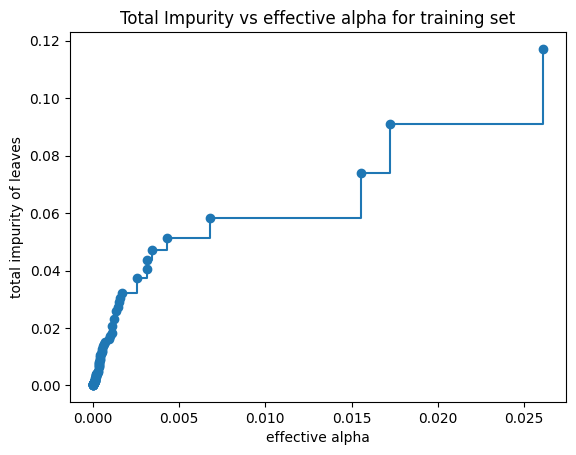

In [10]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [11]:
# train

# alpha 마다의 cost_complexity 값 구한거!
regs = []
for ccp_alpha in ccp_alphas:
    reg_dt = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    reg_dt.fit(X_train, y_train)
    regs.append(reg_dt)
    
# clfs
# [DecisionTreeRegressor(random_state=42),
#  DecisionTreeRegressor(ccp_alpha=2.3684757858670008e-17, random_state=42),
#  DecisionTreeRegressor(ccp_alpha=9.473903143468003e-17, random_state=42),

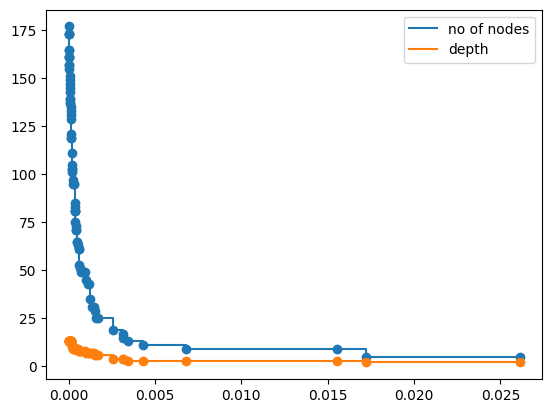

In [12]:
regs = regs[:-1] # 왜..?
ccp_alphas = ccp_alphas[:-1]

node_counts = [reg.tree_.node_count for reg in regs]
depth = [reg.tree_.max_depth for reg in regs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

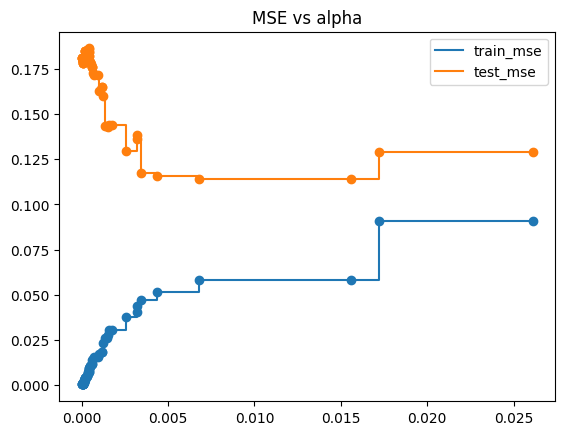

Best alpha: 0.00679


In [13]:
train_mse = []
test_mse = []
for reg in regs:
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    train_mse.append(((y_train - y_train_pred)**2).mean())
    test_mse.append(((y_test - y_test_pred)**2).mean())

plt.scatter(ccp_alphas,train_mse)
plt.scatter(ccp_alphas,test_mse)
plt.plot(ccp_alphas,train_mse,label='train_mse',drawstyle="steps-post")
plt.plot(ccp_alphas,test_mse,label='test_mse',drawstyle="steps-post")
plt.legend()
plt.title('MSE vs alpha')
plt.show()

best_alpha = round(ccp_alphas[test_mse.index(min(test_mse))], 5)
print(f"Best alpha: {best_alpha}")

## Best Tree

In [14]:
best_reg_dt = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)
best_reg_dt.fit(X_train, y_train)

reg_y_train = best_reg_dt.predict(X_train)
reg_y_test = best_reg_dt.predict(X_test)

best_reg_train_mse = ((y_train - reg_y_train)**2).mean()
best_reg_test_mse = ((y_test - reg_y_test)**2).mean()

print(f"MSE of the Best Regression Tree train : {round(best_reg_train_mse, 5)}")
print(f"MSE of the Best Regression Tree test  : {round(best_reg_test_mse, 5)}")

MSE of the Best Regression Tree train : 0.05823
MSE of the Best Regression Tree test  : 0.11414


## Visualization

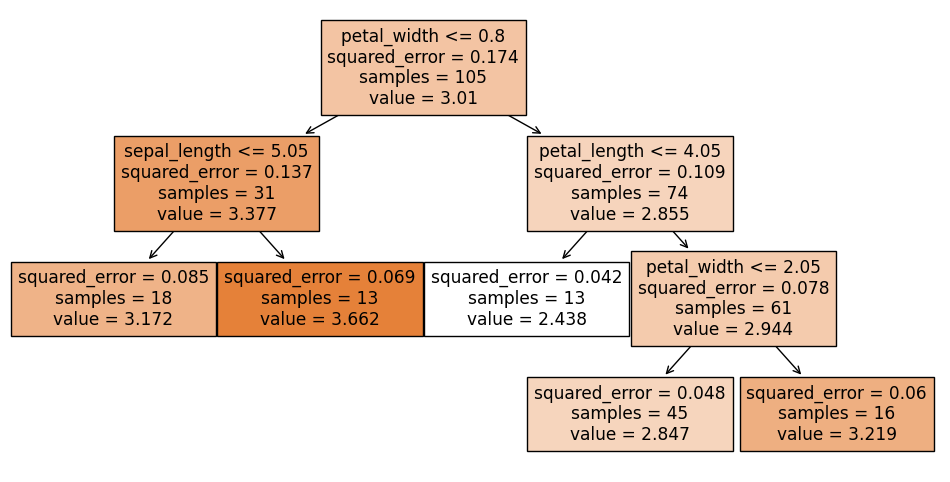

In [15]:
plt.figure(figsize=(12,6))
plot_tree(best_reg_dt,feature_names=X_train.columns,class_names=['setosa', 'versicolor', 'virginica'],filled=True)
plt.show()

## Result

In [16]:
print("============MSE===========")
print("Model\t|Train\t |Test")
print("--------|--------|-------")
print(f"T0\t|{round(reg_train_mse, 5)} |{round(reg_test_mse, 5)}")
print(f"Best\t|{round(best_reg_train_mse, 5)} |{round(best_reg_test_mse, 5)}")
print("==========================")

============MSE===========
Model	|Train	 |Test
--------|--------|-------
T0	|0.00019 |0.17622
Best	|0.05823 |0.11414


# Classification Decision Tree

In [17]:
# dataset titanic
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [18]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [19]:
titanic["sex"] = titanic["sex"].map({"male":1, "female":2}).astype("category")

titanic["age"] = titanic["age"].fillna(titanic["age"].mean())
titanic["embarked"] = titanic["embarked"].map({"S":1, "C":2, "Q":3}).astype("category")
titanic["embarked"] = titanic["embarked"].fillna(titanic["embarked"].mode().values[0])
titanic = titanic.drop(["class", "who", "adult_male", "deck", "embark_town", "alive", "alone"], axis=1)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   survived  891 non-null    int64   
 1   pclass    891 non-null    int64   
 2   sex       891 non-null    category
 3   age       891 non-null    float64 
 4   sibsp     891 non-null    int64   
 5   parch     891 non-null    int64   
 6   fare      891 non-null    float64 
 7   embarked  891 non-null    category
dtypes: category(2), float64(2), int64(4)
memory usage: 43.9 KB


In [20]:
X_titanic = titanic.drop(["survived"], axis=1)
y_titanic = titanic["survived"]

X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size=0.3, random_state=42)
# ============================================
print(f"============ train set ============\nX_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"============ test  set ============\nX_test:  {X_test.shape}, y_test:  {y_test.shape}\n===================================")

============ train set ============
X_train: (623, 7), y_train: (623,)
============ test  set ============
X_test:  (268, 7), y_test:  (268,)


In [56]:
clf_dt = DecisionTreeClassifier(random_state=42) 
clf_dt.fit(X_train, y_train)

clf_y_train = clf_dt.predict(X_train)
clf_y_test = clf_dt.predict(X_test)

clf_train_acc = accuracy_score(y_train, clf_y_train)
clf_test_acc = accuracy_score(y_test, clf_y_test)

print(f"Accuracy of Classification Tree train : {round((clf_train_acc)*100, 2)}")
print(f"Accuracy of Classification Tree test  : {round((clf_test_acc)*100, 2)}")

Accuracy of Classification Tree train : 98.07
Accuracy of Classification Tree test  : 74.63


## Visualization

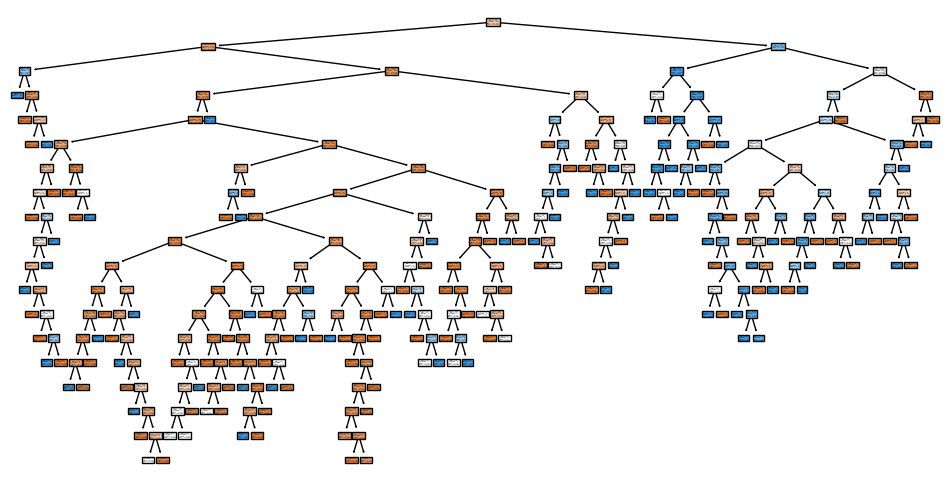

In [57]:
plt.figure(figsize=(12,6))
plot_tree(clf_dt, filled=True, feature_names=X_train.columns, class_names=["survived", "died"])
plt.show()

## pruning

In [58]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
# 'ccp_alphas': array([0.00000000e+00, 5.07406617e-17, 3.38353684e-17, 4.76190476e-05,
# 'impurities': array([0.00019048, 0.00019048, 0.00019048, 0.00025397, 0.00030159,

ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas = np.abs(ccp_alphas) # 부동 소수점에 의한 음수값 없애기 위한 작업

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

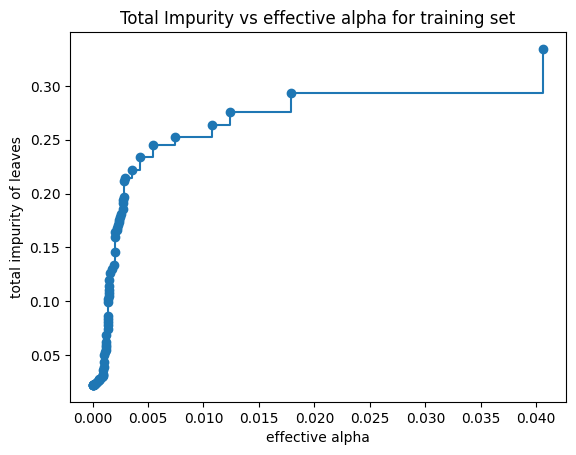

In [59]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [60]:
# train

# alpha 마다의 cost_complexity 값 구한거!
clfs = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clfs.append(clf_dt)
    
# clfs
# [DecisionTreeRegressor(random_state=42),
#  DecisionTreeRegressor(ccp_alpha=2.3684757858670008e-17, random_state=42),
#  DecisionTreeRegressor(ccp_alpha=9.473903143468003e-17, random_state=42),

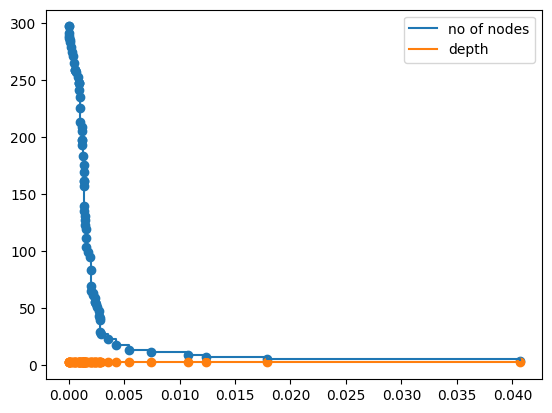

In [61]:
clfs = clfs[:-1] # 왜..?
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [reg.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

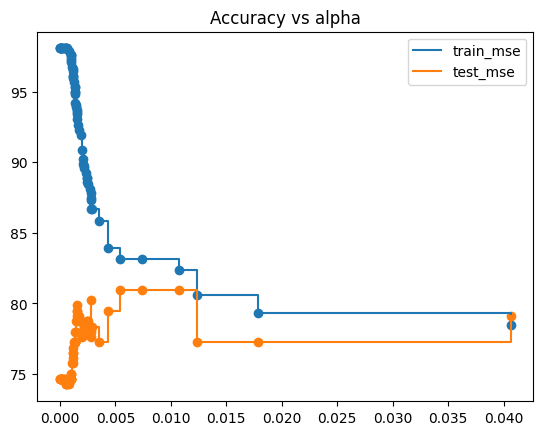

Best alpha: 0.00054


In [62]:
train_acc = []
test_acc = []
for clf in clfs:
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_acc.append(round((accuracy_score(y_train, y_train_pred)*100), 2))
    test_acc.append(round((accuracy_score(y_test, y_test_pred)*100), 2))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_mse',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_mse',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

best_alpha = round(ccp_alphas[test_acc.index(min(test_acc))], 5)
print(f"Best alpha: {best_alpha}")

## Best Tree

In [66]:
best_clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
best_clf_dt.fit(X_train, y_train)

clf_y_train = best_clf_dt.predict(X_train)
clf_y_test = best_clf_dt.predict(X_test)

best_clf_train_acc = accuracy_score(y_train, clf_y_train)
best_clf_test_acc = accuracy_score(y_test, clf_y_test)

print(f"Accuracy of the Best Regression Tree train : {round((best_clf_train_acc)*100, 5)}")
print(f"Accuracy of the Best Regression Tree test  : {round((best_clf_test_acc)*100, 5)}")

# ccp default도 0이라서 성능차이 거의 없음

Accuracy of the Best Regression Tree train : 98.07384
Accuracy of the Best Regression Tree test  : 74.25373


## Visulaization

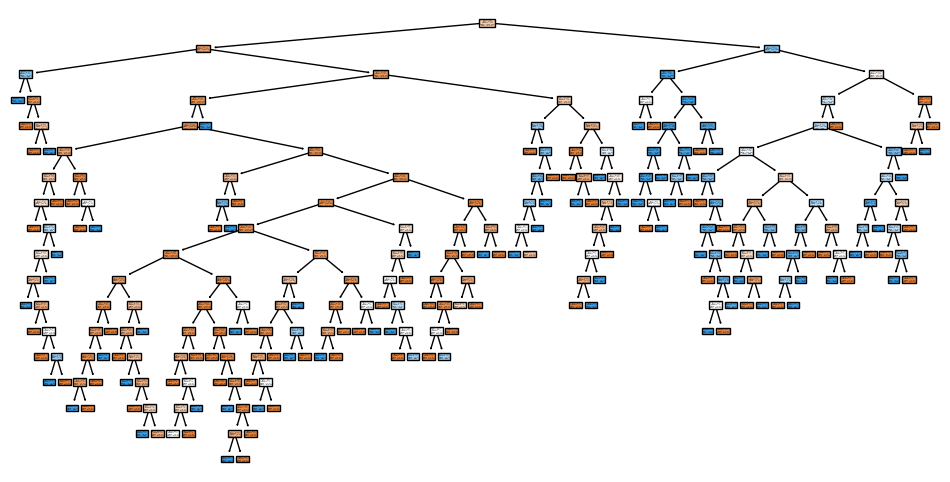

In [67]:
plt.figure(figsize=(12,6))
plot_tree(best_clf_dt,feature_names=X_train.columns,class_names=["survived", "died"],filled=True)
plt.show()

## Result

In [68]:
print("================Accuracy==============")
print("Model\t\t\t|Train\t|Test")
print("------------------------|-------|-----")
print(f"T0\t\t\t|{round((clf_train_acc)*100, 2)}\t|{round((clf_test_acc)*100, 2)}")
print(f"Best\t\t\t|{round((best_clf_train_acc)*100, 2)}\t|{round((best_clf_test_acc)*100, 2)}")
print("======================================")

================Accuracy==============
Model			|Train	|Test
------------------------|-------|-----
T0			|98.07	|74.63
Best			|98.07	|74.25
